Using device: cuda


100%|██████████| 1000/1000 [00:34<00:00, 29.11it/s]


Reward length: 1000
Loss length: 17886


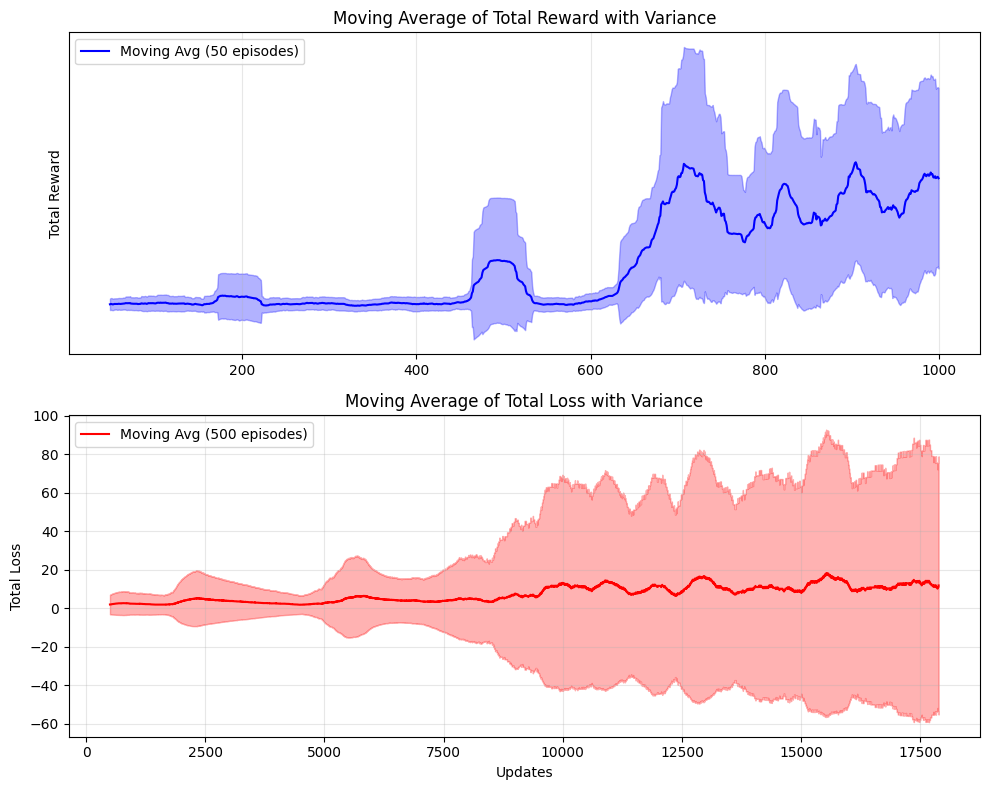

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import json
import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class CosineActivation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.cos(x)

class Estimator(object):
    def __init__(self, state_dim = 4, action_dim = 2, hidden_dim = 100, lr = 0.0001, activation = 'cos'):

        if activation == 'cos':
            activation = CosineActivation()
        elif activation == 'sigmoid':
            activation = torch.nn.Sigmoid()
        elif activation == 'tanh':
            activation = torch.nn.Tanh()

        ## TODO 1: Implement the estimator
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(state_dim, hidden_dim),
            activation,
            torch.nn.Linear(hidden_dim, action_dim)
        ).to(device)
        ## END TODO

        self._initialize_weights_and_bias(state_dim, hidden_dim)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = lr)

    """
    def _initialize_weights_and_bias(self, state_dim = 4, hidden_dim = 100):
        # Initialize the weights and biases of the first layer
        # the first weight is a state_dim x hidden_dim matrix.
        # Initialize each row with a normal distribution with mean 0 and standard deviation sqrt((i+1) * 0.5), where i is the row index.
        # the bias is uniformly distributed between 0 and 2 pi
        for i in range(state_dim):
            torch.nn.init.normal_(self.model[0].weight[i], mean = 0, std = np.sqrt((i+1) * 0.5))
        torch.nn.init.uniform_(self.model[0].bias, a = 0, b = 2 * np.pi)
    """

    def _initialize_weights_and_bias(self, state_dim=4, hidden_dim=100):
        gamma_values = [5.0, 2.0, 1.0, 0.5]  # specified gamma values for each input feature

        for k in range(state_dim):  # for each input feature (k = 0..3)
            std = np.sqrt(2 * gamma_values[k])  # compute the required standard deviation
            torch.nn.init.normal_(self.model[0].weight[:, k], mean=0, std=std)  # initialize all connections from input k to hidden neurons

        # initialize the biases uniformly between 0 and 2π
        torch.nn.init.uniform_(self.model[0].bias, a=0, b=2 * np.pi)


    def update(self, state, y):
        state_tensor = torch.tensor(state, device=device, dtype=torch.float32)
        target_tensor = torch.tensor(y, device=device, dtype=torch.float32)

        y_pred = self.model(state_tensor)
        loss = self.criterion(y_pred, target_tensor)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def predict(self, state):
        with torch.no_grad():
            if self.model is None:
                return np.zeros((2,))
            state_tensor = torch.tensor(state, device=device, dtype=torch.float32)
            return self.model(state_tensor).cpu()



def select_action(state, epsilon, model):
    ## TODO 2: Implement the epsilon-greedy policy
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        q_values = model.predict(state)
        action = torch.argmax(q_values).item()

    ## END TODO
    return action

def q_learning(
    env,
    model,
    episodes,
    decay = False,
    gamma = 0.9,
    epsilon = 0.1,
    eps_decay = 0.9,
):

    total_reward = []
    total_loss = []

    for episode in tqdm.tqdm(range(episodes)):
        state, _ = env.reset()

        done = False
        episode_reward = 0

        while not done:
            action = select_action(state, epsilon, model)

            step_res = env.step(action)
            next_state, reward, done, _, _ = step_res
            episode_reward += reward

            # TODO 3: Implement the Q-learning update rule, using the model.predict and model.update functions
            # predict the q values for the current state
            q_values = model.predict(state)
            q_values = q_values.clone().detach().numpy()

            # If the episode is done, the q value for the action taken should be the reward
            if done:
                q_values[action] = reward

                # compute the loss using the model.update() method which also updates the model
                loss = model.update(state, q_values)
                total_loss.append(loss)
                break

            # otherwise, predict the q values for the next state and use them as the TD target for the update
            q_values_next = model.predict(next_state)

            # Set the q value for the action taken to the TD target
            q_values[action] = reward + gamma * torch.max(q_values_next).item()

            # compute the loss using the model.update() which also updates the model
            loss = model.update(state, q_values)
            total_loss.append(loss)

            state = next_state

        # Update epsilon
        if decay:
            epsilon = max(epsilon * eps_decay, 0.001)

        total_reward.append(episode_reward)

    return total_reward, total_loss


def moving_average_with_variance(data, window_size=50):
    """Calculate moving average and variance over the given window size."""
    if len(data) < window_size:
        return [], [], []

    indices = np.arange(window_size - 1, len(data))
    means = []
    upper_bounds = []
    lower_bounds = []

    for i in range(window_size - 1, len(data)):
        window = data[i - window_size + 1 : i + 1]
        mean_val = np.mean(window)
        std_val = np.std(window)
        means.append(mean_val)
        upper_bounds.append(mean_val + std_val)
        lower_bounds.append(mean_val - std_val)

    return indices, means, [lower_bounds, upper_bounds]

if __name__ == '__main__':

    env = gym.make("CartPole-v1", max_episode_steps=100)
    env.reset(seed=42)

    spec = {
        'episodes': 1000,
        'gamma': 1.0,

        # to experiment with
        'activation': 'sigmoid',
        'lr': 0.0005,
        'epsilon': 0.1,
        'decay': False
    }

    estimator = Estimator(
        state_dim = env.observation_space.shape[0],
        action_dim = env.action_space.n,
        hidden_dim = 100,
        lr = spec['lr'],
        activation = spec['activation']
    )

    reward, total_loss = q_learning(
        env,
        estimator,
        spec['episodes'],
        gamma = spec['gamma'],
        epsilon = spec['epsilon'],
        decay = spec['decay']
    )

    # close the environment
    env.close()

    # plot the results, showing loss and reward on a plot with two subplots and displaying a moving average over 50 episodes
    # Create the figure and subplots with shared x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

    print(f"Reward length: {len(reward)}")
    print(f"Loss length: {len(total_loss)}")

    # Process and plot reward data
    x_reward, reward_mean, reward_var = moving_average_with_variance(np.array(reward), window_size=50)
    ax1.plot(x_reward, reward_mean, color='blue', label='Moving Avg (50 episodes)')
    ax1.fill_between(x_reward, reward_var[0], reward_var[1], alpha=0.3, color='blue')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Moving Average of Total Reward with Variance')
    ax1.yaxis.set_major_locator(plt.MultipleLocator(100))
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Process and plot loss data
    x_loss, loss_mean, loss_var = moving_average_with_variance(np.array(total_loss), window_size=500)
    ax2.plot(x_loss, loss_mean, color='red', label='Moving Avg (500 episodes)')
    ax2.fill_between(x_loss, loss_var[0], loss_var[1], alpha=0.3, color='red')
    ax2.set_xlabel('Updates')
    ax2.set_ylabel('Total Loss')
    ax2.set_title('Moving Average of Total Loss with Variance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()